In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import mean_squared_error
import os

data_path = os.path.join(os.getcwd(), "data")
# IEEE Transactions Recommended fonts are:Times New Roman, Helvetica, Arial, Cambria, and Symbol "
plt.rcParams['font.family'] = "arial"

<p>Currently, the XGBoost package from conda-forge channel doesn't support GPU. There is an on-going discussion about this: conda-forge/xgboost-feedstock#26. For now, you should obtain XGBoost from nvidia channel instead:

conda install -c nvidia -c rapidsai py-xgboost

I just tested this command using g4 instance on Amazon EC2.</p>

### Model Definition

This model uses standard linear regression to fit each depth.

In [2]:
class CFModel:
    def __init__(self, depth, data_file='../data/functest.in', norm=1, test_size=0.2, lasso=False):
        '''
        depth - the depth of the continued fraction (note this is 1 indexed, so 1 is the smallest possible depth)
        filename - path and name of the datafile 
        form - either 'GAM' which runs a Generalized Additive Model with splines or
                      'linear' which is standard linear regression
        '''
        self.depth = depth
        self.data_file = data_file
        self.norm = norm
        self.lasso = lasso
        self.read_data()
        
#         self.X = np.c_[self.X, self.pair_interactions()]
        
        if test_size > 0:
            self.X, self.X_test, self.y, self.y_test = train_test_split(self.X, self.y, test_size=test_size)
                
    def read_data(self):
        '''
        Gets the X and y data from a .in file.
        
        The X and y data are stored in the attributes
        self.X and self.y.
        
        self.n is the number of samples, and self.m is the
        number of features
        '''
        with open(self.data_file, 'r') as f:
            n, m = f.readline().split('\t')
            self.n, self.m = int(n), int(m)
            self.X = np.zeros((self.n, self.m))
            self.y = np.zeros((self.n, ))
            for i, line in enumerate(f):
                points = [float(j) for j in line.split('\t')]
                self.y[i] = points[0]
                self.X[i] = points[1:]

        self.min_coeff = np.zeros((self.depth + 2, ))
        self.y /= self.norm
        
    def fit(self):
        '''
        Fits the model on self.X and self.y.
        '''
        yfit = self.y
        self.linear_models = []
        for d in range(self.depth):
            if self.lasso:
                model = Lasso().fit(self.X, yfit)
            else:
                model = LinearRegression().fit(self.X, yfit)
            self.linear_models.append(model)
    
            ypred = self.predict(self.X, d + 1)
        
            residual = yfit - model.predict(self.X)
            
            # min_coeff is the C constant in the algorithm description
            # The reason for including this is that if the fitted linear
            # function has a zero, it creates a pole in the model, as it
            # is in the denominator. Thus, if we make yfit strictly positive,
            # the fitted function won't have a zero in the domain, thus preventing
            # poles. The constant C (or in this case self.min_coeff[d + 1]) just 
            # makes residual strictly positive
            self.min_coeff[d + 1] = np.abs(residual.min()) + 1
            residual = residual + self.min_coeff[d + 1]

            yfit = 1 / residual    
                        
    def predict(self, X_pred, max_depth=None):
        '''
        Predicts the output of the model on X_pred. Note that
        the model must be fitted first.
        
        max_depth - only compute up to (and not including) depth max_depth.
        '''
        if max_depth is None:
            max_depth = self.depth
        if max_depth < 2:
            return self.compute_depth(0, X_pred)
        
        return (self.compute_depth(0, X_pred) + self.compute_recursive(1, X_pred, max_depth, X_pred))
    
    def compute_depth(self, d, X_pred):
        return self.linear_models[d].predict(X_pred)
    
    def compute_recursive(self, d, X_pred, max_depth, X_pred_orig):
        if d == max_depth - 1:
            return (1 / self.compute_depth(d, X_pred)) - self.min_coeff[d]
        
        return (1 / (self.compute_depth(d, X_pred) + self.compute_recursive(d + 1, X_pred, max_depth, X_pred_orig))) - self.min_coeff[d]
    
    def pair_interactions(self, X=None):
        '''
        Augment X by adding metafeatures combining all pairs of variables.
        '''
        if X is None:
            X = self.X
        ind = range(X.shape[1])
        prods = np.array(np.meshgrid(ind, ind)).reshape(2, -1)
        augmented_X = X[:, prods[0]] * X[:, prods[1]]
        return augmented_X
    
    def mse(self, test=False):
        '''
        Computes the mean squared error of a fitted model.
        
        test - whether to compute the test error. If False, computes
        the training error.
        '''
        if test:
            X_pred = self.X_test
            y_true = self.y_test
        else:
            X_pred = self.X
            y_true = self.y
        y_pred = self.predict(X_pred)
        return np.sum((y_pred - y_true)**2) / y_pred.shape[0]
    
    def plot_obsexp(self):
        '''
        Creates an expected vs. observed plot for a fitted model.
        '''
        xx = np.linspace(model.y.min(), model.y.max(), 1000)
        #plt.plot(xx, xx, c='r')
        y_pred = self.predict(self.X)
        plt.scatter(self.y, y_pred, s=3)
        plt.xlabel('Observed Date')
        plt.ylabel('Model Date')
        plt.savefig('obsexp.eps', format='eps')
        #plt.show()

In [6]:
model = xgboost.XGBRegressor(n_estimators=374, learning_rate=0.02, max_depth=16, min_child_weight=1, subsample=0.5)

In [7]:
file = os.path.join(data_path, "superconductivity_lowest-90.in")

model2 = CFModel(1, data_file=file, test_size=0)

In [8]:
model.fit(model2.X, model2.y)

[09:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=16, min_child_weight=1, missing=None, n_estimators=374,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

In [9]:
file = os.path.join(data_path, "superconductivity_highest-10.in")
model3 = CFModel(1, data_file=file, test_size=0)

Text(0, 0.5, 'Predicted Critical Temperature (K)')

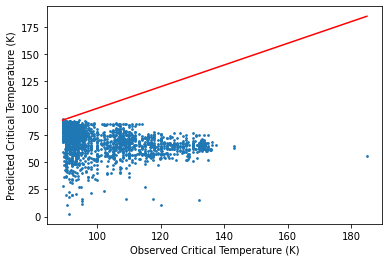

In [10]:
y_true = model3.y
y_pred = model.predict(model3.X)
xx = np.linspace(y_true.min(), y_true.max(), 1000)
plt.plot(xx, xx, color='red')
plt.scatter(y_true, y_pred, s=3)
plt.xlabel('Observed Critical Temperature (K)')
plt.ylabel('Predicted Critical Temperature (K)')
#plt.savefig('xgboost_out_sample.eps', format='eps')

In [11]:
np.sqrt(np.sum((y_true - y_pred)**2) / y_true.shape[0])

36.25649289615321

In [13]:
import pandas as pd
prev_obsrvd = {"predicted":y_pred, "observed": y_true}
df = pd.DataFrame(prev_obsrvd)
df.head()

,predicted,observed
0,85.573357,89.0
1,86.943901,89.0
2,76.603348,89.0
3,69.905998,89.0
4,85.870911,89.0


In [14]:
# top 10 predicted temperatures values
df.nlargest(10, ['predicted']) 

,predicted,observed
31,89.642960,89.20
1086,89.192184,94.20
126,88.690552,89.88
140,88.342285,89.93
213,88.151123,90.00
266,88.151123,90.10
395,88.151123,91.00
513,88.151123,91.30
1225,88.151123,96.10
184,88.102150,90.00


In [16]:
df.nlargest(10, ['predicted']).mean()

predicted    88.472575
observed     91.171000
dtype: float64